<a href="https://colab.research.google.com/github/backkerrmutt/Img_Pro-Mini_Project/blob/main/Image_Processing_mini_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Clone โปรเจกต์

In [ ]:
!git clone https://github.com/tranleanh/haze-synthesis.git

fatal: destination path 'haze-synthesis' already exists and is not an empty directory.


2. ติดตั้ง dependencies ที่จำเป็น
ติดตั้ง scikit-image และ opencv-python-headless เพื่อติดตั้งไลบรารีที่จำเป็นในโปรเจกต์นี้:

In [ ]:
!pip install scikit-image opencv-python-headless

3. อัพโหลดไฟล์ภาพของคุณ
ใช้คำสั่ง files.upload() เพื่อนำไฟล์ภาพจากเครื่องคอมพิวเตอร์ของคุณขึ้น Colab:

In [ ]:
from google.colab import files
uploaded = files.upload()

หลังจากใช้ files.upload() เพื่ออัปโหลดไฟล์แล้ว คุณสามารถย้ายไฟล์ไปยังโฟลเดอร์ inputs ใน Google Colab ได้ด้วยคำสั่งต่อไปนี้:

In [ ]:
import shutil
import os

# สร้างโฟลเดอร์ input ถ้ายังไม่มี
os.makedirs("/content/haze-synthesis/inputs", exist_ok=True)

# ย้ายไฟล์ที่อัปโหลดไปไว้ในโฟลเดอร์ inputs
for filename in uploaded.keys():
    shutil.move(filename, "/content/haze-synthesis/inputs/")


4. ทำการ download model

In [ ]:
# สร้างโฟลเดอร์ใหม่เพื่อเก็บไฟล์โมเดล
# !mkdir -p /content/haze-synthesis/models/mono+stereo_640x192

# ดาวน์โหลดไฟล์ ZIP ของโมเดล
!wget https://storage.googleapis.com/niantic-lon-static/research/monodepth2/stereo_640x192.zip -P /content/haze-synthesis/models/mono+stereo_640x192

# แตกไฟล์ ZIP ไปที่โฟลเดอร์ที่กำหนด
!unzip /content/haze-synthesis/models/mono+stereo_640x192/stereo_640x192.zip -d /content/haze-synthesis/models/mono+stereo_640x192

# ตรวจสอบว่าไฟล์ที่แตกออกมาแล้วมีอะไรบ้าง
!ls /content/haze-synthesis/models/mono+stereo_640x192


--2025-03-23 08:36:45--  https://storage.googleapis.com/niantic-lon-static/research/monodepth2/stereo_640x192.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.153.207, 142.250.145.207, 74.125.128.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.153.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 55174256 (53M) [application/zip]
Saving to: ‘/content/haze-synthesis/models/mono+stereo_640x192/stereo_640x192.zip’

stereo_640x192.zip  100%[===================>]  52.62M   186MB/s    in 0.3s    

2025-03-23 08:36:46 (186 MB/s) - ‘/content/haze-synthesis/models/mono+stereo_640x192/stereo_640x192.zip’ saved [55174256/55174256]

Archive:  /content/haze-synthesis/models/mono+stereo_640x192/stereo_640x192.zip
  inflating: /content/haze-synthesis/models/mono+stereo_640x192/depth.pth  
  inflating: /content/haze-synthesis/models/mono+stereo_640x192/encoder.pth  
depth.pth  encoder.pth	stereo_640x192.zip


5. ทำการ RUN Model และแสดงผลลัพธ์

✅ ล้างข้อมูลเก่าใน /content/haze-synthesis/outputs สำเร็จแล้ว!
✅ รันสำเร็จ: ['/usr/bin/python3', '/content/haze-synthesis/main.py', '--image_path', '/content/haze-synthesis/inputs/img-pro_001.jpg', '--output_image_path', '/content/haze-synthesis/outputs', '--model_name', 'mono+stereo_640x192', '--beta', '1.0', '--airlight', '150']
✅ รันสำเร็จ: ['/usr/bin/python3', '/content/haze-synthesis/main.py', '--image_path', '/content/haze-synthesis/inputs/img-pro_001.jpg', '--output_image_path', '/content/haze-synthesis/outputs', '--model_name', 'mono+stereo_640x192', '--beta', '1.5', '--airlight', '150']
✅ รันสำเร็จ: ['/usr/bin/python3', '/content/haze-synthesis/main.py', '--image_path', '/content/haze-synthesis/inputs/img-pro_001.jpg', '--output_image_path', '/content/haze-synthesis/outputs', '--model_name', 'mono+stereo_640x192', '--beta', '2.0', '--airlight', '150']
✅ รันสำเร็จ: ['/usr/bin/python3', '/content/haze-synthesis/main.py', '--image_path', '/content/haze-synthesis/inputs/img-pro_00

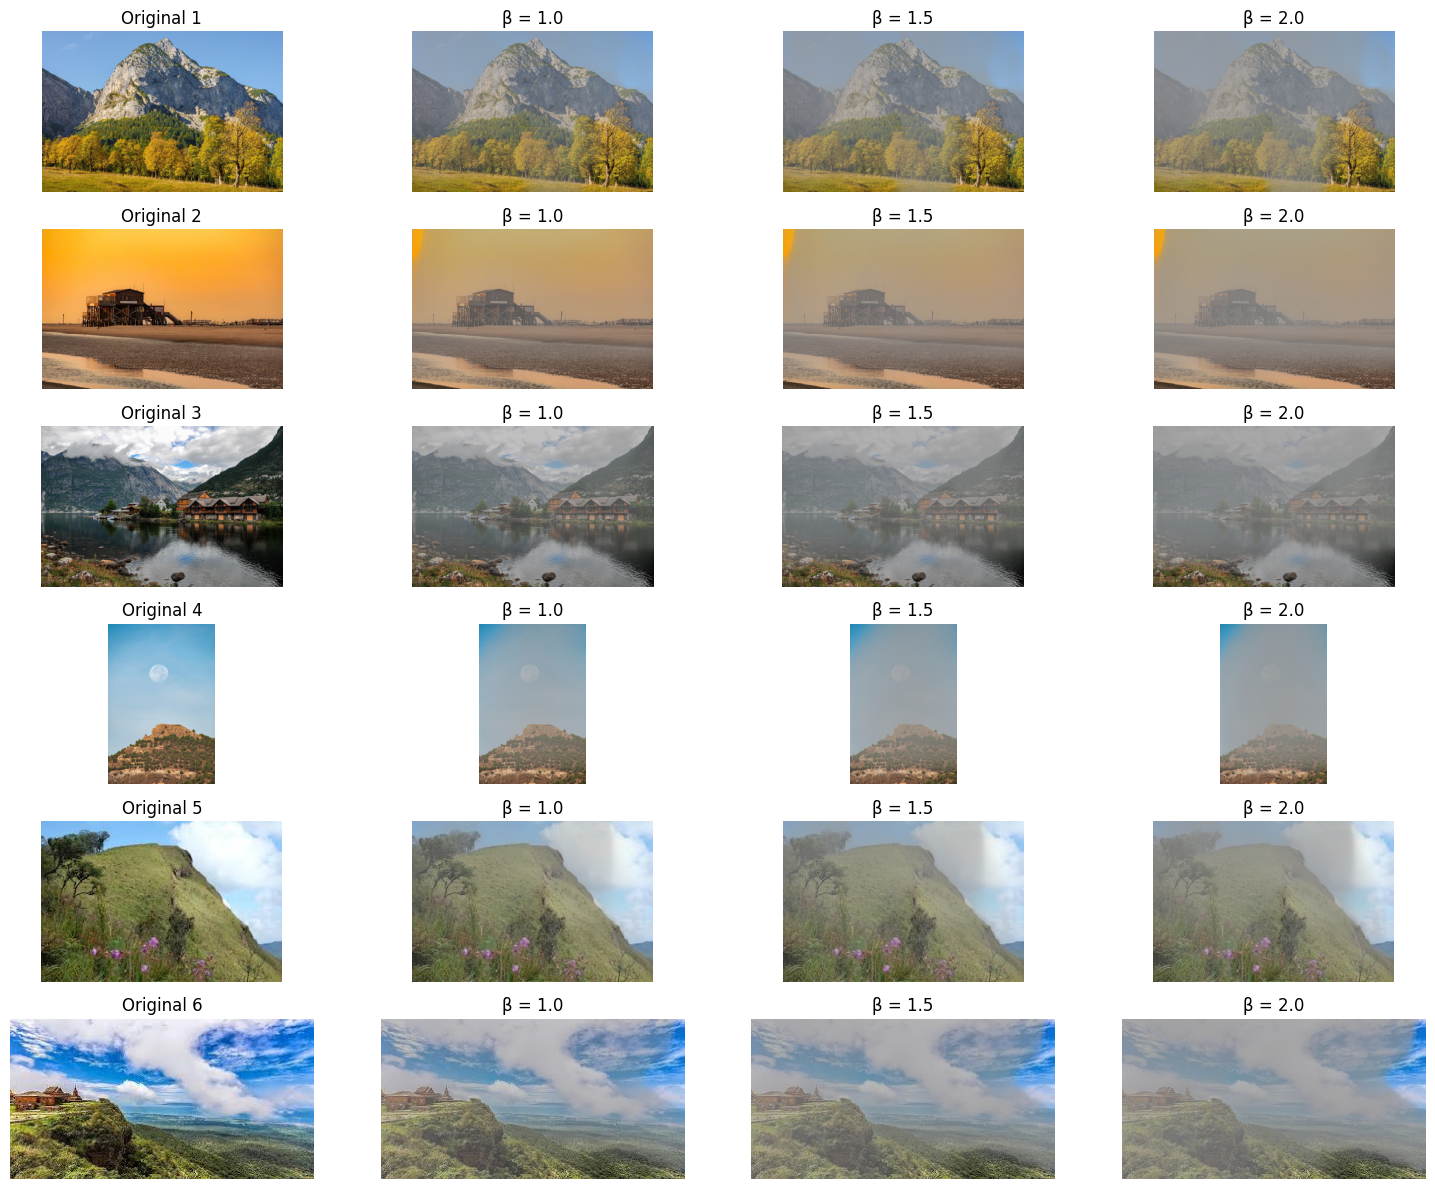

In [24]:
import os
import cv2
import sys
import subprocess
import matplotlib.pyplot as plt

# 🛠 กำหนดพารามิเตอร์ของโมเดล
beta_values = [1.0, 1.5, 2.0]  # ค่าของ beta ที่ต้องการรัน
airlight = 150
input_path = "/content/haze-synthesis/inputs"
output_path = "/content/haze-synthesis/outputs"
model_name = "mono+stereo_640x192"

# 🗑️ ฟังก์ชันลบไฟล์เก่าทั้งหมดใน output
def clear_output_folder(output_folder):
    if os.path.exists(output_folder):
        for file in os.listdir(output_folder):
            file_path = os.path.join(output_folder, file)
            if os.path.isfile(file_path):
                os.remove(file_path)
        print(f"✅ ล้างข้อมูลเก่าใน {output_folder} สำเร็จแล้ว!")
    else:
        os.makedirs(output_folder)  # ถ้าไม่มีโฟลเดอร์ ให้สร้างใหม่
        print(f"📂 สร้างโฟลเดอร์ {output_folder}")

# 🔥 ลบไฟล์เก่าก่อนเริ่มรันโมเดล
clear_output_folder(output_path)

# 🛠 ตรวจสอบว่าโฟลเดอร์ inputs และ main.py มีอยู่จริง
if not os.path.exists(input_path):
    raise FileNotFoundError(f"❌ ไม่พบโฟลเดอร์ {input_path}")
if not os.path.exists("/content/haze-synthesis/main.py"):
    raise FileNotFoundError("❌ ไม่พบไฟล์ main.py ใน /content/haze-synthesis/")

# 🔄 วนลูปรูปทั้งหมดใน inputs
input_images = sorted(os.listdir(input_path))  # เรียงชื่อไฟล์
input_images = [f for f in input_images if f.lower().endswith((".jpg", ".png", ".jpeg"))]  # กรองเอาเฉพาะไฟล์รูปภาพ

for img_name in input_images:
    img_path = os.path.join(input_path, img_name)

    # 🔄 รันโมเดลที่ beta = 1.0, 1.5, 2.0
    for beta in beta_values:
        command = [
            sys.executable, "/content/haze-synthesis/main.py",
            "--image_path", img_path,
            "--output_image_path", output_path,
            "--model_name", model_name,
            "--beta", str(beta),
            "--airlight", str(airlight)
        ]

        try:
            result = subprocess.run(command, check=True, capture_output=True, text=True)
            print(f"✅ รันสำเร็จ: {command}")
        except subprocess.CalledProcessError as e:
            print(f"❌ ERROR: คำสั่ง {command} ล้มเหลว")
            print(f"🔴 stdout:\n{e.stdout}")
            print(f"🔴 stderr:\n{e.stderr}")
            continue  # ข้ามไปทำรูปอื่น

        # 📝 เปลี่ยนชื่อไฟล์ผลลัพธ์ให้ชัดเจน
        output_file = f"{os.path.splitext(img_name)[0]}_synt.jpg"
        output_path_old = os.path.join(output_path, output_file)
        output_path_new = os.path.join(output_path, f"{os.path.splitext(img_name)[0]}_synt_beta{beta}.jpg")

        if os.path.exists(output_path_old):  # เช็คว่าผลลัพธ์มีอยู่จริง
            os.rename(output_path_old, output_path_new)

# 📸 แสดงภาพ (Original + Beta 1.0, 1.5, 2.0)
plt.figure(figsize=(15, 12))

for i, img_name in enumerate(input_images):  # วนลูปทุกภาพใน input
    img_path = os.path.join(input_path, img_name)

    # ✅ โหลดภาพต้นฉบับ
    img = cv2.imread(img_path)
    if img is None:
        print(f"❌ ไม่พบไฟล์: {img_path}")
        continue
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(len(input_images), 4, i*4 + 1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Original {i+1}")  # ✅ แก้ให้เริ่มที่ 1

    # ✅ โหลดภาพที่ผ่านโมเดล (beta = 1.0, 1.5, 2.0)
    for j, beta in enumerate(beta_values):
        img_hazy_name = f"{os.path.splitext(img_name)[0]}_synt_beta{beta}.jpg"
        img_hazy_path = os.path.join(output_path, img_hazy_name)

        if not os.path.exists(img_hazy_path):
            print(f"⚠️ ไม่พบไฟล์: {img_hazy_path}")
            continue

        img_hazy = cv2.imread(img_hazy_path)
        img_hazy = cv2.cvtColor(img_hazy, cv2.COLOR_BGR2RGB)

        plt.subplot(len(input_images), 4, i*4 + j + 2)
        plt.imshow(img_hazy)
        plt.axis("off")
        plt.title(f"β = {beta}")

plt.tight_layout()
plt.show()
